# <center> Train XGBoost Classifier </center>

Now let's see if we can improve on our simple logistic regression model by using boosted decision trees. I will use the following blog post as a baseline for the hyperparameter tuning of my model: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/. The post mentioned above uses grid search for tuning while I have decided to use randomized search.

Loasing xgboost will throw a warning because the version I have installed seems to reference to a deprecated scikit module.

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from time import time
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score
from capstone_project import utility

%matplotlib inline

/home/andre/software/anaconda3/envs/capstone_project/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Load the data:

In [2]:
file_directory = "../output/data/"

train_data = utility.load_pickle(file_directory, "train_features.pkl")
val_data = utility.load_pickle(file_directory, "val_features.pkl")
train_labels = utility.load_pickle(file_directory, "train_labels.pkl")
val_labels = utility.load_pickle(file_directory, "val_labels.pkl")

Define inital parameters for XGBoost Classifier:

In [3]:
learning_rate = 0.2
n_estimators = 1000
max_depth = 10
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
objective = "binary:logistic"
nthread = 4
scale_pos_weight = 1
reg_alpha=0
seed = 3453

Fit estimator with initial parameters to find best number of estimators for a high learning rate:


Best number of iterations: 388

     test-logloss-mean  test-logloss-std  train-logloss-mean  \
378           0.418590          0.001890            0.209098   
379           0.418586          0.001894            0.208871   
380           0.418607          0.001849            0.208545   
381           0.418554          0.001861            0.208121   
382           0.418552          0.001850            0.207838   
383           0.418556          0.001836            0.207480   
384           0.418529          0.001809            0.207185   
385           0.418521          0.001817            0.206768   
386           0.418535          0.001836            0.206410   
387           0.418508          0.001847            0.206093   

     train-logloss-std  
378           0.000665  
379           0.000689  
380           0.000729  
381           0.000834  
382           0.000858  
383           0.000914  
384           0.000907  
385           0.000905  
386           0.000834  
387         

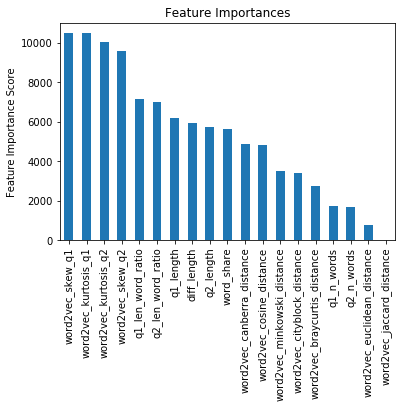

In [4]:
clf = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                         min_child_weight=min_child_weight, gamma=gamma, subsample=subsample,
                         colsample_bytree=colsample_bytree, objective=objective, nthread=nthread,
                         scale_pos_weight=scale_pos_weight, reg_alpha=reg_alpha, seed=seed)

plt = utility.xgb_fit_model(clf, train_data, train_labels)
plt.show()

In [5]:
n_estimators = 388

Now we'll use grid search to tune the maximum depth and minimum child weight. These parameters are tuned first because they should have the largest impact on  model performance.

In [6]:
param_dist = {"max_depth": randint(6,16), #randint takes min and max values as parameters
              "min_child_weight": randint(1,6)}

n_iter_search = 10  # Number of searches in Randomized search

random_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                                                               max_depth=max_depth, min_child_weight=min_child_weight, 
                                                               gamma=gamma, subsample=subsample, 
                                                               colsample_bytree=colsample_bytree, objective=objective, 
                                                               nthread=nthread, scale_pos_weight=scale_pos_weight, 
                                                                reg_alpha=reg_alpha, seed=seed), 
                                 param_distributions = param_dist, n_iter=n_iter_search, 
                                 scoring='neg_log_loss', n_jobs=2, iid=False, cv=5, random_state=329)

print random_search
start = time()
random_search.fit(train_data, train_labels)
print "\nRandomizedSearchCV took {:.2f} minutes for {} candidates parameter settings.".format((time() - start)/60, n_iter_search)
utility.report(random_search.cv_results_)  

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=388, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=3453, silent=True, subsample=0.8),
          fit_params={}, iid=False, n_iter=10, n_jobs=2,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0e1700f250>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0e1700fa90>},
          pre_dispatch='2*n_jobs', random_state=329, refit=True,
          return_train_score=True, scoring='neg_log_loss', verbose=0)

RandomizedSearchCV took 63.93 minutes for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.418 (std: 0.002)
Parameters: {'max_depth': 10, 'min_child_weight': 1}



In [7]:
# Best model score 0.418
max_depth = 10
min_child_weight = 1

Next we'll tune the gamme value:

In [8]:
param_dist = {"gamma": uniform(0, 0.5)}

n_iter_search = 5  # Number of searches in Randomized search


random_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                                                               max_depth=max_depth, min_child_weight=min_child_weight, 
                                                               gamma=gamma, subsample=subsample, 
                                                               colsample_bytree=colsample_bytree, objective=objective, 
                                                               nthread=nthread, scale_pos_weight=scale_pos_weight, 
                                                                reg_alpha=reg_alpha, seed=seed), 
                                 param_distributions = param_dist, n_iter=n_iter_search, 
                                 scoring='neg_log_loss', n_jobs=2, iid=False, cv=5, random_state=329)

print random_search
start = time()
random_search.fit(train_data, train_labels)
print "\nRandomizedSearchCV took {:.2f} minutes for {} candidates parameter settings.".format((time() - start)/60, n_iter_search)
utility.report(random_search.cv_results_)  


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=388, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=3453, silent=True, subsample=0.8),
          fit_params={}, iid=False, n_iter=5, n_jobs=2,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0e106da7d0>},
          pre_dispatch='2*n_jobs', random_state=329, refit=True,
          return_train_score=True, scoring='neg_log_loss', verbose=0)

RandomizedSearchCV took 28.42 minutes for 5 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.418 (std: 0.001)
Parameters: {'gamma': 0.37496144849819074}

Model with rank: 2
Mean validation score: -0.418 (std: 0.002)
Parameters: {'gamma': 0.19548480844969679}

Mo

In [13]:
# val score 0.418
gamma = 0.37

At this point we'll change the subsample and subsample_bytree parameters:

In [14]:
param_dist = {"subsample": uniform (0.5, 0.4),  # Uniform takes minimum value and range as parameters
              "colsample_bytree": uniform (0.5, 0.4)}

n_iter_search = 8  # Number of searches in Randomized search


random_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                                                               max_depth=max_depth, min_child_weight=min_child_weight, 
                                                               gamma=gamma, subsample=subsample, 
                                                               colsample_bytree=colsample_bytree, objective=objective, 
                                                               nthread=nthread, scale_pos_weight=scale_pos_weight, 
                                                                reg_alpha=reg_alpha, seed=seed), 
                                 param_distributions = param_dist, n_iter=n_iter_search, 
                                 scoring='neg_log_loss', n_jobs=2, iid=False, cv=5, random_state=329)

print random_search
start = time()
random_search.fit(train_data, train_labels)
print "\nRandomizedSearchCV took {:.2f} minutes for {} candidates parameter settings.".format((time() - start)/60, n_iter_search)
utility.report(random_search.cv_results_)  


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.722,
       gamma=0.37, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=388, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=3453, silent=True, subsample=0.854),
          fit_params={}, iid=False, n_iter=8, n_jobs=2,
          param_distributions={'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0e106cfb10>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0e106cfb50>},
          pre_dispatch='2*n_jobs', random_state=329, refit=True,
          return_train_score=True, scoring='neg_log_loss', verbose=0)

RandomizedSearchCV took 42.91 minutes for 8 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.416 (std: 0.001)
Parameters: {'subsample': 0.85397536224441539, 'c

In [15]:
# loss is 0.416
subsample = 0.854 
colsample_bytree = 0.722

In the next step we are going to tune the regularization parameter:

In [16]:
param_dist = { 'reg_alpha': uniform(0,5)} # Uniform takes minimum value and range as parameters
n_iter_search = 10  # Number of searches in Randomized search

random_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                                                               max_depth=max_depth, min_child_weight=min_child_weight, 
                                                               gamma=gamma, subsample=subsample, 
                                                               colsample_bytree=colsample_bytree, objective=objective, 
                                                               nthread=nthread, scale_pos_weight=scale_pos_weight, 
                                                                reg_alpha=reg_alpha, seed=seed), 
                                 param_distributions = param_dist, n_iter=n_iter_search, 
                                 scoring='neg_log_loss', n_jobs=2, iid=False, cv=5, random_state=329)

print random_search
start = time()
random_search.fit(train_data, train_labels)
print "\nRandomizedSearchCV took {:.2f} minutes for {} candidates parameter settings.".format((time() - start)/60, n_iter_search)
utility.report(random_search.cv_results_)  


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.722,
       gamma=0.37, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=388, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=3453, silent=True, subsample=0.854),
          fit_params={}, iid=False, n_iter=10, n_jobs=2,
          param_distributions={'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0e106cf510>},
          pre_dispatch='2*n_jobs', random_state=329, refit=True,
          return_train_score=True, scoring='neg_log_loss', verbose=0)

RandomizedSearchCV took 52.33 minutes for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.415 (std: 0.001)
Parameters: {'reg_alpha': 1.5291099932912744}

Model with rank: 2
Mean validation score: -0.416 (std: 0.002)
Parameters: {'reg_alpha': 1.95

Now we can set the new regularization parameter. This was the lest parameter that we had to tune. Now it is time to decrease the learning rate, increase the number of estimators and fit the tuned model on the whole dataset again. The function xgb_fit_model uses cross fold validation and early stopping to find the best number of estimators and then fits the model again using the found number of estimators. 

In [17]:
#best model 0.415
reg_alpha = 1.529
learning_rate = 0.01
n_estimators = 50000

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.722,
       gamma=0.37, learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=50000, nthread=4,
       objective='binary:logistic', reg_alpha=1.529, reg_lambda=1,
       scale_pos_weight=1, seed=3453, silent=True, subsample=0.854)

Best number of iterations: 10598

       test-logloss-mean  test-logloss-std  train-logloss-mean  \
10588           0.397972          0.001584            0.172079   
10589           0.397971          0.001583            0.172068   
10590           0.397971          0.001585            0.172058   
10591           0.397971          0.001584            0.172048   
10592           0.397971          0.001584            0.172034   
10593           0.397971          0.001585            0.172023   
10594           0.397969          0.001584            0.172009   
10595           0.397969          0.001585            0.171998   
10596           0.

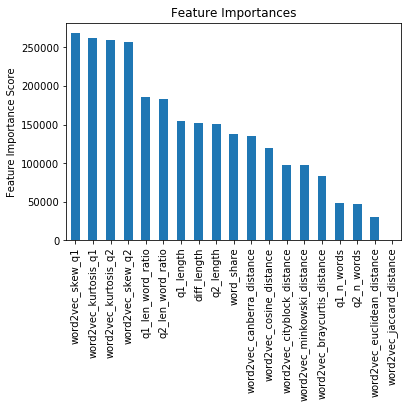

In [18]:
clf = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                         min_child_weight=min_child_weight, gamma=gamma, subsample=subsample,
                         colsample_bytree=colsample_bytree, objective=objective, nthread=nthread,
                         scale_pos_weight=scale_pos_weight, reg_alpha=reg_alpha, seed=seed)

print clf
start = time()
utility.xgb_fit_model(clf, train_data, train_labels)
print "\nXGB fitting took {:.2f} minutes.".format((time() - start)/60)


In [19]:
model_directory = "../output/models/"
prefix = "for_validation_"

utility.save_pickle(clf, model_directory, prefix+"xgboost.pkl") 

In [20]:
model_directory = "../output/models/"
clf = utility.load_pickle(model_directory, "for_validation_xgboost.pkl")

predictions= clf.predict_proba(val_data)[:, 1] 

In [21]:
loss = log_loss(val_labels, predictions)
acc = accuracy_score(val_labels, np.rint(predictions))

print "Validation scores for the xgboost classifier\n LogLoss: {:.4f}\n Accuracy: {:.2f} ".format(loss, acc)

Validation scores for the xgboost classifier
 LogLoss: 0.3903
 Accuracy: 0.79 


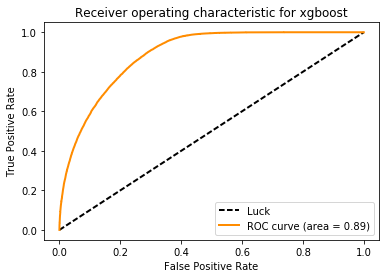

In [22]:
plt = utility.create_roc_plot(val_labels, predictions, "xgboost")
plt.savefig("../output/figures/xgboost_roc_plot.png")
plt.show()